# Doodle-Classifier

We have some data from Kaggle that is obtained from the game Quick, Draw! where players will draw a picture based on a given word. One thing to keep in mind is that the data is labelled solely based on the what the player has been given. This means that doodles may be incomplete or not anywhere close to what a typical image of what that said picture looks like. The goal of this project is to work towards the given Kaggle goal while having smaller personal goals that apply other data science/machine learning techniques.

Original Goal from Kaggle: Find a way to parse through the data and build a better classifier that can effectively learn from the noisy data set. 

Personal Ideas/Goals: 
- Use the SVD to find dominant shapes? 
- Count how many strokes are in each picture
- Find a criteria that throw out images 

# Load Data

In [1]:
import os 
import ndjson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
F = 'data'
files = os.listdir(F)

# load from file-like objects
file_p = F + '\\' + files[4]
with open(file_p) as f:
    data = ndjson.load(f)

In [5]:
data[0]

{'word': 'bus',
 'countrycode': 'GB',
 'timestamp': '2017-03-09 16:12:35.55741 UTC',
 'recognized': True,
 'key_id': '6312143085371392',
 'drawing': [[[83, 77, 64, 56, 51, 51, 58, 74, 87, 91, 83, 76, 75],
   [98, 95, 97, 102, 110, 118, 127, 129, 121, 110, 100, 98, 101]],
  [[202, 186, 172, 164, 158, 160, 164, 184, 207, 214, 214, 199, 174],
   [98, 97, 100, 106, 115, 127, 130, 136, 129, 122, 115, 103, 100]],
  [[0, 123, 201, 236, 235, 227, 219, 192, 140, 102, 19, 11, 11],
   [98, 98, 91, 96, 59, 15, 6, 1, 0, 4, 19, 63, 104]],
  [[226, 212, 200, 209, 215, 219, 255], [9, 10, 15, 37, 66, 69, 64]],
  [[38, 41, 45, 79, 81, 79, 69, 54, 38], [34, 55, 58, 54, 47, 32, 21, 19, 28]],
  [[103, 107, 112, 127, 151, 146, 137, 107], [24, 49, 50, 44, 44, 31, 21, 21]],
  [[165, 168, 173, 194], [23, 40, 48, 41]]]}

In [6]:
type(data)

list

In [3]:
df = pd.DataFrame(data)
df.head(5)

,countrycode,drawing,key_id,recognized,timestamp,word
0,GB,"[[[83, 77, 64, 56, 51, 51, 58, 74, 87, 91, 83,...",6312143085371392,True,2017-03-09 16:12:35.55741 UTC,bus
1,US,"[[[3, 1, 39, 46, 47, 178, 254, 244, 145, 12], ...",6409748716978176,True,2017-03-23 22:40:24.04445 UTC,bus
2,IT,"[[[7, 6, 8], [14, 56, 63]], [[9, 14, 81, 154, ...",5500039466057728,True,2017-01-28 10:36:39.17377 UTC,bus
3,US,"[[[62, 67, 66, 48, 6, 3, 0, 3, 6, 72, 205, 247...",5401115073970176,True,2017-03-19 01:55:44.68666 UTC,bus
4,GB,"[[[209, 113, 25, 6, 3, 0, 0, 6, 138, 248, 248,...",6025066867326976,True,2017-03-04 11:04:28.86581 UTC,bus


# Data Exploration

We will see that our data contains the following interesting features: word (the word being drawn), 'key_id' (unique id for doodle), and 'drawing' which is an array of vectors that contain the (x,y) coordinate pair of strokes of the doodle. Starting with some data exploration, we can look at a few things. Let's start witht he number of strokes per each picture.

In [21]:
# Calculate the number of strokes per a drawing
strokes = df['drawing']
stroke_num = []
for s in strokes:
    stroke_num.append(len(s))

In [24]:
df['strokes_num'] = stroke_num
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word,strokes_num
0,GB,"[[[83, 77, 64, 56, 51, 51, 58, 74, 87, 91, 83,...",6312143085371392,True,2017-03-09 16:12:35.55741 UTC,bus,7
1,US,"[[[3, 1, 39, 46, 47, 178, 254, 244, 145, 12], ...",6409748716978176,True,2017-03-23 22:40:24.04445 UTC,bus,4
2,IT,"[[[7, 6, 8], [14, 56, 63]], [[9, 14, 81, 154, ...",5500039466057728,True,2017-01-28 10:36:39.17377 UTC,bus,13
3,US,"[[[62, 67, 66, 48, 6, 3, 0, 3, 6, 72, 205, 247...",5401115073970176,True,2017-03-19 01:55:44.68666 UTC,bus,9
4,GB,"[[[209, 113, 25, 6, 3, 0, 0, 6, 138, 248, 248,...",6025066867326976,True,2017-03-04 11:04:28.86581 UTC,bus,10


In [45]:
word = df['word']
print(len(word))

166208


In [42]:
# Confirm that we're only looking at the doodles of a 'bus'
print(word.eq('bus').sum())

166208


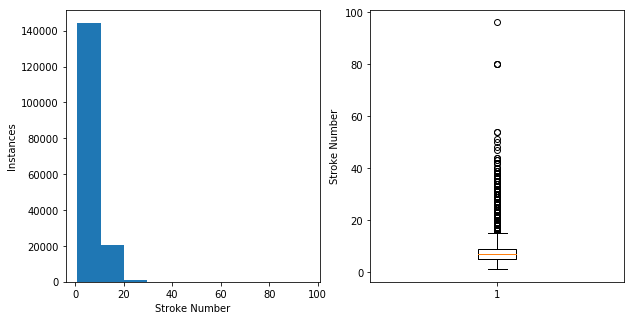

In [37]:
# Plot number of strokes on a histogram and box plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(stroke_num)
ax[0].set_xlabel('Stroke Number')
ax[0].set_ylabel('Instances')
ax[1].boxplot(stroke_num)
ax[1].set_ylabel('Stroke Number')
plt.show()

Amazingly, there seem to be some people who used more than 100 strokes to draw the bus. Instinctively, one would think that this could serve as a criteria for removing images. Since this is a long tailed distribution, let's remove the outliers from the top x percent and look at the data again. 

In [54]:
# Use Z-score to find the outliers 
from scipy import stats

z_score = np.abs(stats.zscore(stroke_num))

# Print how many elements will be removed
threshold = 5
tz = np.where(z_score > threshold)
print(np.shape(tz))

(1, 338)


In [57]:
# Remove outliers from DataFrame
print('Old Shape: {}'.format(np.shape(df)))
df_0 = df[(z_score < threshold)]
print('New Shape: {}'.format(np.shape(df_0)))

Old Shape: (166208, 7)
New Shape: (165870, 7)


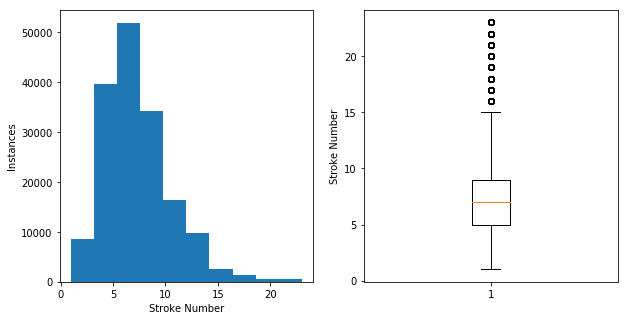

In [58]:
# New Histogram
stroke_num = df_0['strokes_num']
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(stroke_num)
ax[0].set_xlabel('Stroke Number')
ax[0].set_ylabel('Instances')
ax[1].boxplot(stroke_num)
ax[1].set_ylabel('Stroke Number')
plt.show()

# SVD 

In [5]:
# Get'drawing' aspect or the strokes made from the dataframe
strokes = df['drawing']

(105, 176, 4)

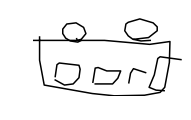

In [15]:
# Plot one image from strokes and save the images 
stroke = strokes[0]
fig = plt.figure(frameon=False)
fig.set_size_inches(2.7,1.56)
fig.tight_layout(pad = 0)
ax = fig.add_subplot(111)
ax.set_xlim(0,260)
ax.set_ylim(0,150)
ax.axis('off')
for s in stroke:
    ax.plot(s[0], s[1], 'k')
fig.canvas.draw()
plt.savefig('test.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0)
pic = plt.imread('test.png')

pic.shape

In [16]:
# Function recieves colored image as a 3D matrix as input and converts it into a 2D grayscale image.
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

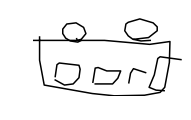

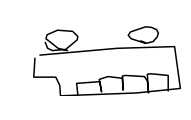

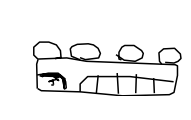

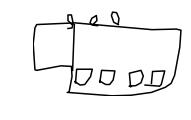

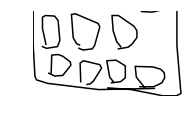

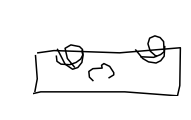

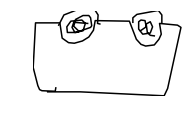

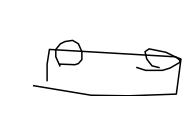

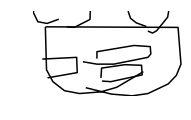

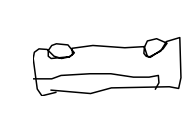

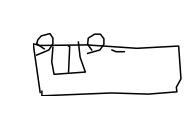

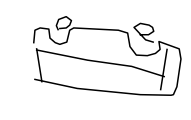

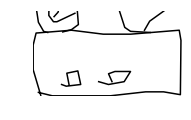

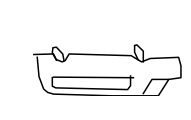

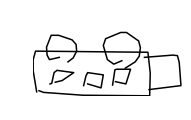

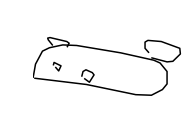

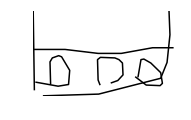

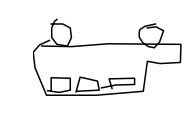

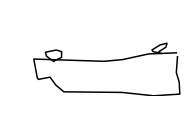

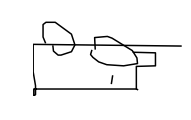

In [22]:
# Save each image and then reshapes them into a large matrix so that we can apply the SVD
draw_num = 20
width = pic.shape[1]
height = pic.shape[0]
drawing_mat = np.zeros([width*height, draw_num])
k = 0
for stroke in strokes[0:draw_num]:
    # %% Plot image from strokes and save the images 
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2.7,1.56)
    fig.tight_layout(pad = 0)
    ax = fig.add_subplot(111)
    ax.set_xlim(0,260)
    ax.set_ylim(0,150)
    ax.axis('off')
    for s in stroke:
        ax.plot(s[0], s[1], 'k')
    fig.canvas.draw()
    plt.savefig('test.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0)
    pic = plt.imread('test.png')
    drawing_mat[:, k] = np.reshape(rgb2gray(pic), (width*height))
    k = k+1

In [23]:
drawing_mat.shape

(18480, 20)

In [24]:
import numpy.linalg as la

u, s, vh = la.svd(drawing_mat)

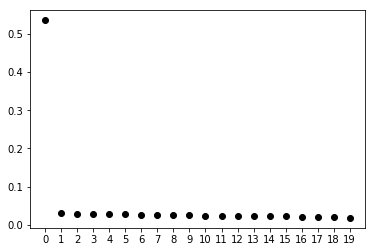

In [35]:
plt.plot(s/sum(s), 'ko')
plt.xticks(np.arange(draw_num))
plt.show()

array([575.70763141,  32.42086293,  31.46146497,  31.21266554,
        29.55844566,  29.13172061,  28.92642583,  27.69478953,
        26.74952669,  26.41758266,  26.12415814,  25.51992994,
        25.42040138,  24.80785791,  24.02883787,  23.63773588,
        22.95379787,  22.23538322,  20.72154801,  19.41777854])